# Exploratory Data Analysis (EDA) for Clustering

## Introduction

In this notebook, we will investigate the validity of the risk labels and study unsupervised clustering algorithm.

**Conclusions from this notebook:**

- We have found that the data points were not distinct in the 3D plane, indicating that the risk labels might not be sufficiently reliable.
- Visually, clustering algorithm provides more distinguishable clusters that are more equally distributed with clear boundaries.
- We can also inspect all the attributes of each data point and compare the similarity within the intra-cluster and inter-cluster boundary in Tensorflow Embedding Projector.

## Imports

In [1]:
import math

import numpy as np
import openpyxl
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotnine as p9
import spacy
import umap
from kmodes.kprototypes import KPrototypes
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

pio.renderers.default = "png"
pd.set_option("display.max_columns", None)

### Read in Preprocessing Train Set

In [2]:
train_df = pd.read_excel(
    "../../data/processed/preprocessed_train.xlsx",
)
train_df.head()

,is_pii,is_fii,NRI score,authentication_processed,usage_base_processed,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,Government & Public Services,Health Science & Medicine,Information & Science,Justice & Public Safety,Logistics & Infrastructure,Natural Resources & Energy,News & Media,None,Religion & Spirituality,Research & Education,Sales & Marketing,Security & Technology,Skills & Career Development,Social Media & Technology,Software & Services,Sports & Entertainment,Transportation & Automobile,Work & Personal Life,eCommerce & Trade,"Food, Health & Medicine",server_name_processed,security_test_result_processed,x0_Broken Authentication,x0_Cross-Site Scripting,x0_Insecure Deserialization,x0_Missing,x0_SQL Injection,x0_XML External Entities,x-frame-options,x-xss-protection,strict-transport-security,expect-ct,referrer-policy,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count,Risk_Label
0,True,False,77.850013,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,Low
1,True,False,77.850013,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,6,1,Low
2,False,False,76.479613,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,3,1,Medium
3,True,False,76.479613,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,5,0,Low
4,True,False,77.850013,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,3,Low


In [3]:
y_train = train_df["Risk_Label"]
train_df = train_df.drop(
    columns=[
        "NRI score",
        "usage_base_processed",
        "security_test_result_processed",
        "authentication_processed",
        "server_name_processed",
        "AI & Data Science",
        "Business & Technology",
        "Environment & Weather",
        "Finance & Banking",
        "Food, Health & Medicine",
        "GeoInformatics & Navigation",
        "Government & Public Services",
        "Health Science & Medicine",
        "Information & Science",
        "Justice & Public Safety",
        "Logistics & Infrastructure",
        "Natural Resources & Energy",
        "News & Media",
        "None",
        "Religion & Spirituality",
        "Research & Education",
        "Sales & Marketing",
        "Security & Technology",
        "Skills & Career Development",
        "Social Media & Technology",
        "Software & Services",
        "Sports & Entertainment",
        "Transportation & Automobile",
        "Work & Personal Life",
        "eCommerce & Trade",
        "expect-ct",
        "set-cookie",
        "access-control-allow-origin",
        "x-powered-by",
        "x-aspnet-version", 
        "x-ratelimit-limit",
        "x0_Broken Authentication",
        "x0_Cross-Site Scripting",
        "x0_Insecure Deserialization",
        "x0_Missing",
        "x0_SQL Injection",
        "x0_XML External Entities",
        "Risk_Label",
    ]
)
train_df.head()

,is_pii,is_fii,x-frame-options,x-xss-protection,strict-transport-security,referrer-policy,content-type,server,metadata_fields_count,parameters_count
0,True,False,0,0,1,0,0,0,2,2
1,True,False,0,1,1,1,0,1,6,1
2,False,False,1,0,0,0,0,1,3,1
3,True,False,1,1,0,1,1,0,5,0
4,True,False,0,0,1,0,0,0,2,3


<hr />



## Encoding
> We separated all columns into categorical and numerical variables

In [4]:
numerical_features = ["metadata_fields_count", "parameters_count"]
categorical_features = list(train_df.drop(numerical_features, axis=1).columns.values)
categorical_idx = [
    train_df.columns.get_loc(c) for c in categorical_features if c in train_df
]
train_df[categorical_features] = train_df[categorical_features].astype(str)

## K-Prototypes
> We used Elbow curve method to find the optimal number of clusters

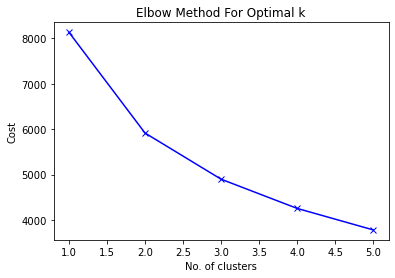

In [5]:
# Elbow curve to find optimal K
cost = []
K = range(1, 6)
for num_clusters in list(K):
    kproto = KPrototypes(
        n_clusters=num_clusters, init="Cao", n_init=10, n_jobs=-1, random_state=123
    )
    kproto.fit_predict(train_df, categorical=categorical_idx)
    cost.append(kproto.cost_)

plt.plot(K, cost, "bx-")
plt.xlabel("No. of clusters")
plt.ylabel("Cost")
plt.title("Elbow Method For Optimal k")
plt.show()

> We can see a bend at K=2 in the above graph indicating 2 or 3 are the optimal number of clusters.

## Cluster Centroids

In [6]:
kproto = KPrototypes(n_clusters=3, init="Cao", n_init=10, n_jobs=-1, random_state=123)
kproto.fit_predict(train_df, categorical=categorical_idx)
# Print the cluster centroids
pd.DataFrame(
    kproto.cluster_centroids_, columns=numerical_features + categorical_features
)

,metadata_fields_count,parameters_count,is_pii,is_fii,x-frame-options,x-xss-protection,strict-transport-security,referrer-policy,content-type,server
0,4.285714285714286,4.319327731092437,True,False,0,0,0,0,0,1
1,2.558599695585997,1.1080669710806696,False,False,0,0,0,0,0,1
2,5.094444444444444,1.0592592592592593,True,False,1,0,0,0,0,1


## Visualization

In [14]:
# Utility Function for visualization
def calculate_zscore(df, columns):
    """
    scales columns in dataframe using z-score
    """
    df = df.copy()
    for col in columns:
        df[col] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

    return df


def one_hot_encode(df, columns):
    """
    one hot encodes list of columns and
    concatenates them to the original df
    """

    concat_df = pd.concat(
        [pd.get_dummies(df[col], drop_first=True, prefix=col) for col in columns],
        axis=1,
    )
    one_hot_cols = concat_df.columns

    return concat_df, one_hot_cols


def normalize_column_modality(df, columns):
    """
    divides each column by the probability μₘ of the modality
    (number of ones in the column divided by N) only for one hot columns
    """

    length = len(df)
    for col in columns:

        weight = math.sqrt(sum(df[col]) / length)
        df[col] = df[col] / weight

    return df


def center_columns(df, columns):
    """
    center columns by subtracting the mean value
    """
    for col in columns:
        df[col] = df[col] - df[col].mean()

    return df


def FAMD_(df, n_components, numerical_features, categorical_features):
    """
    Factorial Analysis of Mixed Data (FAMD),
    which generalizes the Principal Component Analysis (PCA)
    algorithm to datasets containing numerical and categorical variables

    a) For the numerical variables
      - Standard scale (= get the z-score)

    b) For the categorical variables:
      - Get the one-hot encoded columns
      - Divide each column by the square root of its probability sqrt(μₘ)
      - Center the columns

    c) Apply a PCA algorithm over the table obtained!

    """

    variable_distances = []

    numeric_cols = df[numerical_features]
    cat_cols = df[categorical_features]

    # numeric process
    normalized_df = calculate_zscore(df, numeric_cols)
    normalized_df = normalized_df[numeric_cols.columns]

    # categorical process
    cat_one_hot_df, one_hot_cols = one_hot_encode(df, cat_cols)
    cat_one_hot_norm_df = normalize_column_modality(cat_one_hot_df, one_hot_cols)
    cat_one_hot_norm_center_df = center_columns(cat_one_hot_norm_df, one_hot_cols)
    
    # Merge DataFrames
    processed_df = pd.concat([normalized_df, cat_one_hot_norm_center_df], axis=1)

    # Perform (PCA)
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(processed_df)

    return principalComponents

In [15]:
k_protype_data = train_df.copy()

numeric_cols = k_protype_data[numerical_features]
cat_cols = k_protype_data[categorical_features]
kproto = KPrototypes(n_clusters=3, init="Cao", n_jobs=-1, random_state=123)

clusters = kproto.fit_predict(k_protype_data, categorical=categorical_idx)

FAMD_data = train_df.copy()
FAMD_components = FAMD_(FAMD_data, 3, numerical_features, categorical_features)

k_proto_umap = pd.DataFrame(
    {
        "x": FAMD_components[:, 0],
        "y": FAMD_components[:, 1],
        "z": FAMD_components[:, 2],
        "clusters": clusters,
        "target": y_train,
    }
)


k_proto_umap["clusters"] = k_proto_umap["clusters"].apply(str)

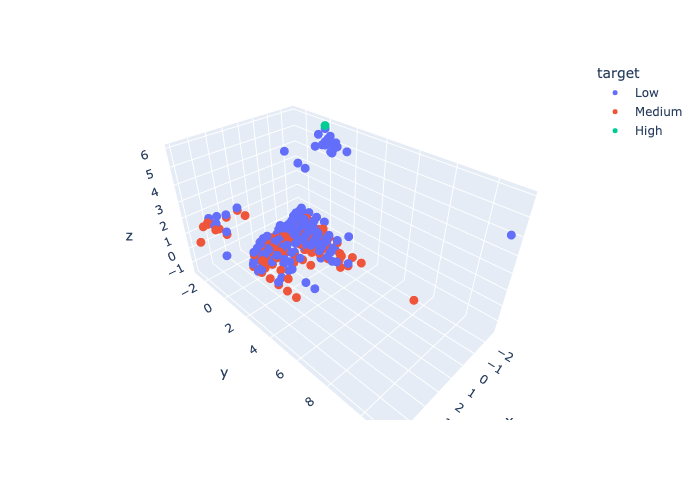

In [16]:
fig_3d = px.scatter_3d(
    k_proto_umap, x="x", y="y", z="z", color="target", labels={"color": "target"}
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

> We have found that the data points were not distinct in the 3D plane, indicating that the risk labels might not be sufficiently reliable.

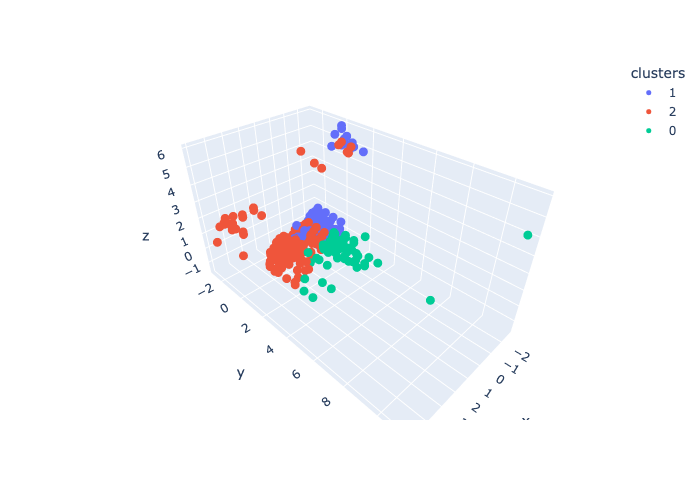

In [10]:
fig_3d = px.scatter_3d(
    k_proto_umap, x="x", y="y", z="z", color="clusters", labels={"color": "Cluster"}
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

> Visually, K-Prototypes Clustering Algorithm,  provides more distinguishable clusters that are more equally distributed with clear boundaries.

In [11]:
final_df = pd.concat([k_proto_umap, train_df], axis=1)

## Tensorflow Embedding Projector

In [12]:
pd.DataFrame(
    {
        "x": FAMD_components[:, 0],
        "y": FAMD_components[:, 1],
        "z": FAMD_components[:, 2],
    }
).to_csv("vector.tsv", index=False, header=False, sep='\t')

In [13]:
final_df = pd.concat([train_df, pd.DataFrame(
    {
        "clusters": clusters,
        "target": y_train,
    }
)], axis=1)
final_df["clusters"] = final_df["clusters"].apply(str)
final_df.to_csv("metadata.tsv", index=False, header=True, sep='\t')

> We exported vector.tsv and metadata.tsv for visualization. Go to https://projector.tensorflow.org/ and upload these two files for further investigation